# **COVID FAKE NEWS CLASSIFICATION**

Covid fake/real news dataset link : https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/corona_fake.csv

In [ ]:
# Connect to the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Command line, in order to install the packages
!pip install catboost
!pip install tweepy
!pip install wordcloud

In [ ]:
#Importing useful libraries
import requests
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
import tweepy
import re
import string
import seaborn as sns
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from heapq import nlargest
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore') # To remove the warnings

# To preprocess the data
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### User defined Function

In [ ]:
stop_words = set(stopwords.words('english'))

#function for preprocessing text; stopwords removal, lemmatization, punctuation removal, etc.
def preprocess_text(text):
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9]+)"," ",text).split())
  text = text.translate(str.maketrans('', '', string.punctuation))
  text_tokens = word_tokenize(text)
  cleaned_text = [WordNetLemmatizer().lemmatize(word) for word in text_tokens if not word in stop_words]
  processed_text = " ".join(cleaned_text)
  return processed_text

#function to convert words into vector matrix
def tfidf_vector(text):
    tfidf = TfidfVectorizer(sublinear_tf=True)     
    tfidf.fit(text)                           
    return tfidf  

#function to make n-trigrams of text
def top_n_trigram(corpus, num=10):
    cvect = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bagofwords = cvect.transform(corpus)
    sum_of_words = bagofwords.sum(axis=0) 
    words_frequency = [(word, sum_of_words[0, index]) for word, index in cvect.vocabulary_.items()]
    words_frequency =sorted(words_frequency, key = lambda x: x[1], reverse=True)
    return words_frequency[:num]
  
#function to get all hastags of text
def hashtags(text):
    hashs = []
    for t in text:
        tag = re.findall(r'#(\w+)', t)
        hashs.append(tag)
    return hashs

def plot_tags(news_tags, news_type):
  tag_news = Counter(news_tags)
  news_df = pd.DataFrame({'Hash': list(tag_news.keys()),
                    'frequency' : list(tag_news.values())})

  news_df = news_df.nlargest(columns = 'frequency', n = 10)

  plt.figure(figsize = (16,5))
  plt.title('Frequent hashtags for {} news'.format(news_type))
  axs = sns.barplot(data =news_df, x = 'Hash', y = 'frequency')
  plt.xticks(rotation=45)
  plt.show()

#Wordcloud formation forparticular news type
def word_cloud(news_data, label):
  news_words = ' '.join([text for text in news_data['text'][news_data['label'] == label]])
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(news_words)
  plt.figure(figsize=(10, 7))
  plt.title('Wordcloud for {} covid news'.format(label))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()

def trigrams_plot(news_data, n):
  common_news_words = top_n_trigram(news_data.text.to_list(), n)

  ref_data = pd.DataFrame(common_news_words, columns = ['news' , 'frequency'])
  plt.figure(figsize=(12,5))
  ref_data.groupby('news').sum()['frequency'].sort_values(ascending=False).plot(
      kind='bar', color='cadetblue',title='Top {} trigrams in preprocessed news'.format(str(n)))
  plt.ylabel('frequency')
  a = plt.xticks(rotation=45)


def classifier(estimator, Xtrain, ytrain):
  estimator.fit(Xtrain, ytrain)
  pred = estimator.predict(Xtest)
  print('---------------------CLASSIFICATION REPORT----------------------')
  print()
  print(classification_report(ytest, pred))
  print('----------------------------------------------------------------')
  plot_confusion_matrix(estimator = estimator,X=Xtest, y_true= ytest, cmap='Blues_r')
  plt.grid(None)
  plt.show()
  print('----------------------------------------------------------------')
  acc = accuracy_score(ytest, pred)
  from imblearn.metrics import sensitivity_score, specificity_score
  #TN, FP, FN, TP = confusion_matrix(ytest, pred).ravel()
  sensitivity = sensitivity_score(ytest, pred, average='macro')
  specificity = specificity_score(ytest, pred, average='macro')
  print('Accuracy score: ', acc)
  print('Sensitivity score: ', sensitivity)
  print('Specificity score: ', specificity)
  return estimator, acc, sensitivity, specificity


def performance_graph(performance_df):
  fig = px.bar(performance_df, x='Classifier', y='Accuracy_score', text = 'Accuracy_score')
  fig.update_traces(textposition='outside')
  fig.update_layout(
      height=600,
      width=1200,
      title_text='Performace(Accuracy Score) of Classifiers'
  )
  fig.show()

### Loading covid fake-news dataset

In [ ]:
#provide data path
data_path = 'https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/corona_fake.csv'

In [ ]:
#loading dataset from github
fake_news_data = pd.read_csv(data_path)
fake_news_data

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake
...,...,...,...,...
1159,Could the Power of the Sun Slow the Coronavirus?,A study suggests that ultraviolet rays could s...,https://www.nytimes.com/,TRUE
1160,Key evidence for coronavirus spread is flawed ...,"Last week, a medical journal reported that a b...",https://www.nytimes.com/,TRUE
1161,Summer Heat May Not Diminish Coronavirus Strength,"A new report, sent to the White House science ...",https://www.nytimes.com/,TRUE
1162,How Long Will a Vaccine Really Take?,A vaccine would be the ultimate weapon against...,https://www.nytimes.com/,TRUE


In [ ]:
#data carries null values, removing them
fake_news_data = fake_news_data[['text', 'label']]
fake_news_data.dropna(inplace=True)

In [ ]:
#label values count
fake_news_data.label.value_counts()

TRUE    581
Fake    344
fake    226
Name: label, dtype: int64

In [ ]:
#formatting label
fake_news_data.label[fake_news_data.label=='fake'] = 'Fake'
fake_news_data.label[fake_news_data.label=='TRUE'] = 'Real'

In [ ]:
#label values count
fake_news_data.label.value_counts()

Real    581
Fake    570
Name: label, dtype: int64

### Data Exploration and Preprocessing

#### label ratio

Real    581
Fake    570
Name: label, dtype: int64


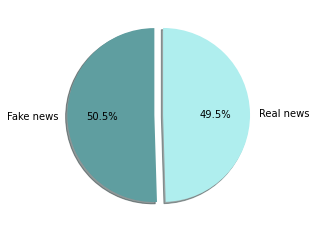

In [ ]:
#pie chart for visualising fake and real news ratio
print(fake_news_data.label.value_counts())
explode = (0, 0.1) 
pie = plt.pie(fake_news_data.label.value_counts(),explode = explode, autopct='%1.1f%%', labels=['Fake news', 'Real news'],
        shadow=True, startangle=90, colors = ['cadetblue', 'paleturquoise'])

#### label count

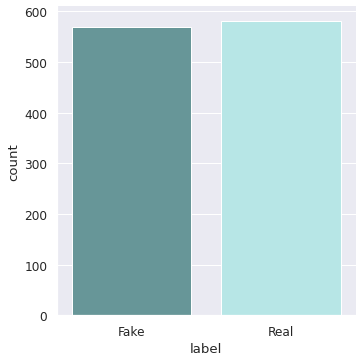

In [ ]:
#Fake and real news count taken from the dataset
sns.set(font_scale=1.1)
catplot = sns.catplot("label", data=fake_news_data, kind="count", height=5, palette=sns.color_palette(['cadetblue', 'paleturquoise']))

#### visualizing hastag counts

In [ ]:
#hastags from news text
tags_real = hashtags(fake_news_data['text'][fake_news_data['label'] == 'Real'])
tags_fake = hashtags(fake_news_data['text'][fake_news_data['label'] == 'Fake'])

tags_real = sum(tags_real, [])
tags_fake = sum(tags_fake, [])

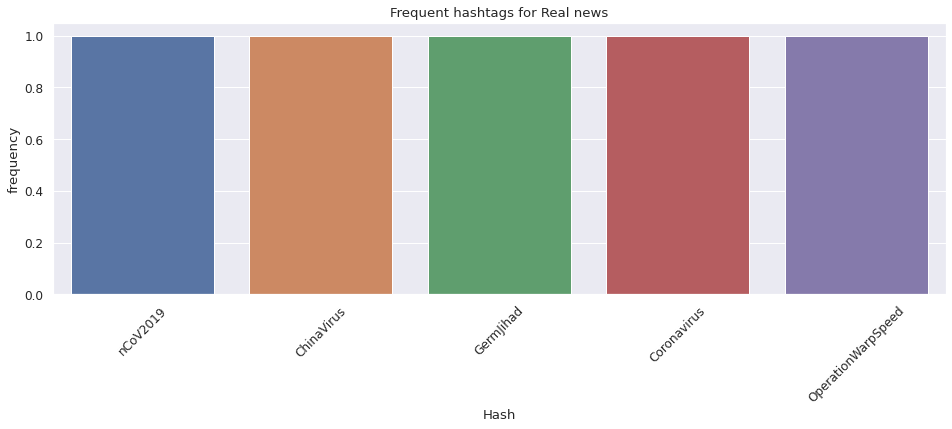

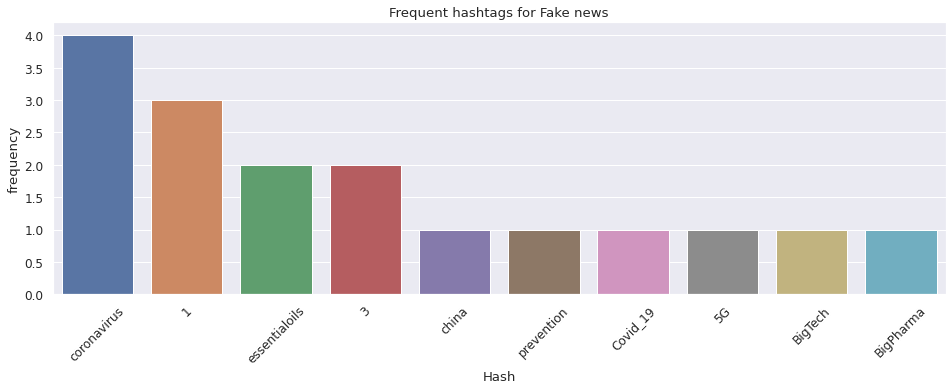

In [ ]:
# making frequency distribution top 10 fake and real news hashtags
plot_tags(tags_real, 'Real')
plot_tags(tags_fake, 'Fake')

#### Data preprocessing

In [ ]:
#preprocessing covid fake news dataset
fake_news_data['text'] =fake_news_data['text'].apply(preprocess_text)

#### keywords plotting(wordcloud)

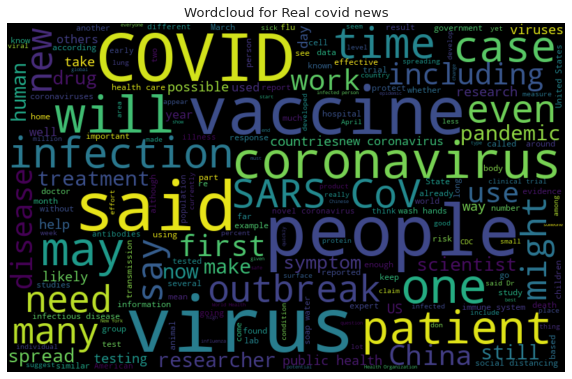

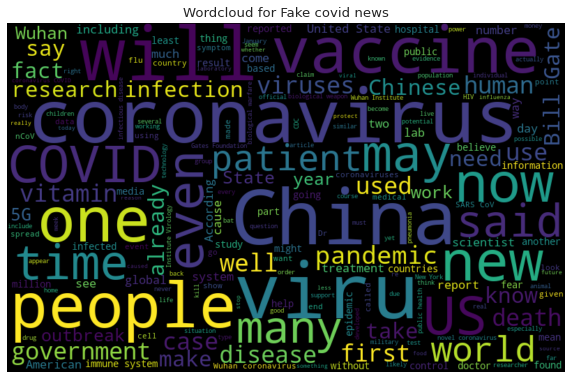

In [ ]:
#wordclouds
word_cloud(fake_news_data, 'Real')
word_cloud(fake_news_data, 'Fake')

#### most frequent trigrams

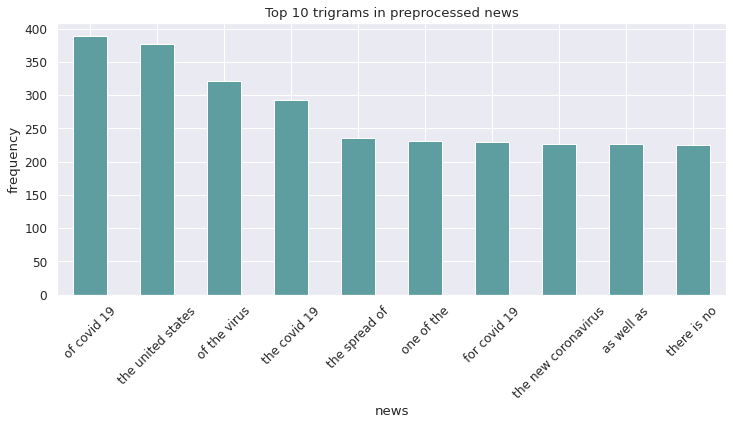

In [ ]:
#trigrams
trigrams_plot(fake_news_data, 10)

### Data preparation

In [ ]:
#converting words into vector matrix
vectorized_text = tfidf_vector(np.array(fake_news_data['text']).ravel())

In [ ]:
#Encoding label
fake_news_data['label'] = LabelEncoder().fit_transform(fake_news_data['label'])

In [ ]:
#separating features and target
X = vectorized_text.transform(np.array(fake_news_data['text']).ravel())   
y = np.array(fake_news_data['label']).ravel() 

### Data Splitting

In [ ]:
#Splitting dataset into training and testing sets with ratio 80:20
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, random_state=30)

### Model building (Classifiers)

We have applies 12 mostly popular classifiers to choose the best out of them.

############## SVC ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       119
           1       0.94      0.96      0.95       112

    accuracy                           0.95       231
   macro avg       0.95      0.95      0.95       231
weighted avg       0.95      0.95      0.95       231

----------------------------------------------------------------


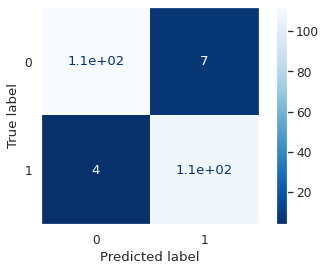

----------------------------------------------------------------
Accuracy score:  0.9523809523809523
Sensitivity score:  0.9527310924369747
Specificity score:  0.9527310924369747
############## Naive Bayes ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.93      0.81      0.86       119
           1       0.82      0.94      0.88       112

    accuracy                           0.87       231
   macro avg       0.88      0.87      0.87       231
weighted avg       0.88      0.87      0.87       231

----------------------------------------------------------------


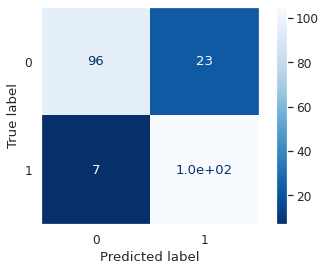

----------------------------------------------------------------
Accuracy score:  0.8701298701298701
Sensitivity score:  0.8721113445378151
Specificity score:  0.8721113445378151
############## Random Forest ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       119
           1       0.89      0.90      0.90       112

    accuracy                           0.90       231
   macro avg       0.90      0.90      0.90       231
weighted avg       0.90      0.90      0.90       231

----------------------------------------------------------------


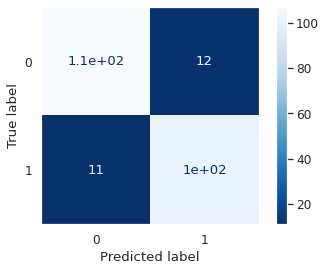

----------------------------------------------------------------
Accuracy score:  0.9004329004329005
Sensitivity score:  0.9004726890756303
Specificity score:  0.9004726890756303
############## XGBoost ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       119
           1       0.91      0.90      0.91       112

    accuracy                           0.91       231
   macro avg       0.91      0.91      0.91       231
weighted avg       0.91      0.91      0.91       231

----------------------------------------------------------------


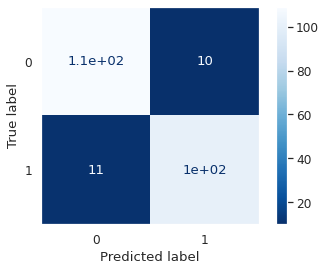

----------------------------------------------------------------
Accuracy score:  0.9090909090909091
Sensitivity score:  0.9088760504201681
Specificity score:  0.9088760504201681
############## AdaBoost ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       119
           1       0.86      0.89      0.88       112

    accuracy                           0.88       231
   macro avg       0.88      0.88      0.88       231
weighted avg       0.88      0.88      0.88       231

----------------------------------------------------------------


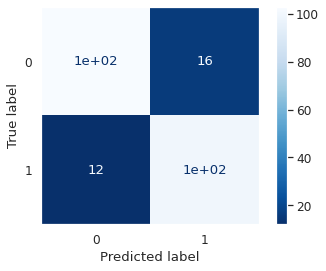

----------------------------------------------------------------
Accuracy score:  0.8787878787878788
Sensitivity score:  0.8792016806722689
Specificity score:  0.8792016806722689
############## ExtraTrees ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       119
           1       0.73      0.73      0.73       112

    accuracy                           0.74       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.74      0.74      0.74       231

----------------------------------------------------------------


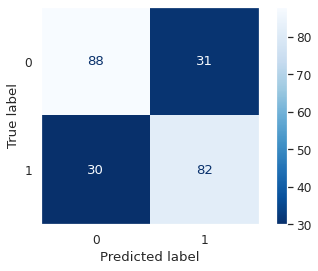

----------------------------------------------------------------
Accuracy score:  0.7359307359307359
Sensitivity score:  0.7358193277310925
Specificity score:  0.7358193277310925
############## KNN ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       119
           1       0.84      0.96      0.90       112

    accuracy                           0.89       231
   macro avg       0.90      0.89      0.89       231
weighted avg       0.90      0.89      0.89       231

----------------------------------------------------------------


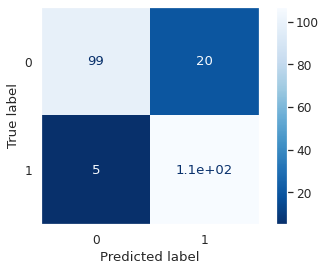

----------------------------------------------------------------
Accuracy score:  0.8917748917748918
Sensitivity score:  0.8936449579831933
Specificity score:  0.8936449579831933
############## Catboost ################
Learning rate set to 0.009942
0:	learn: 0.6898666	total: 551ms	remaining: 9m 10s
1:	learn: 0.6863107	total: 830ms	remaining: 6m 54s
2:	learn: 0.6836505	total: 1.13s	remaining: 6m 15s
3:	learn: 0.6806565	total: 1.41s	remaining: 5m 52s
4:	learn: 0.6779223	total: 1.7s	remaining: 5m 39s
5:	learn: 0.6750875	total: 1.98s	remaining: 5m 28s
6:	learn: 0.6714156	total: 2.28s	remaining: 5m 23s
7:	learn: 0.6681315	total: 2.57s	remaining: 5m 18s
8:	learn: 0.6650278	total: 2.85s	remaining: 5m 13s
9:	learn: 0.6618113	total: 3.15s	remaining: 5m 11s
10:	learn: 0.6590299	total: 3.43s	remaining: 5m 8s
11:	learn: 0.6562782	total: 3.72s	remaining: 5m 6s
12:	learn: 0.6531877	total: 4.01s	remaining: 5m 4s
13:	learn: 0.6507341	total: 4.3s	remaining: 5m 3s
14:	learn: 0.6480146	total: 4.59s	rema

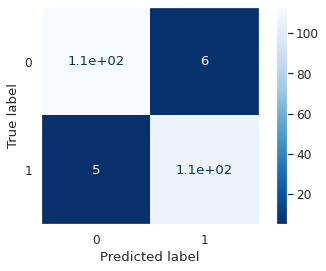

----------------------------------------------------------------
Accuracy score:  0.9523809523809523
Sensitivity score:  0.952468487394958
Specificity score:  0.952468487394958
############## Gradient Boost ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       119
           1       0.95      0.91      0.93       112

    accuracy                           0.94       231
   macro avg       0.94      0.93      0.93       231
weighted avg       0.94      0.94      0.93       231

----------------------------------------------------------------


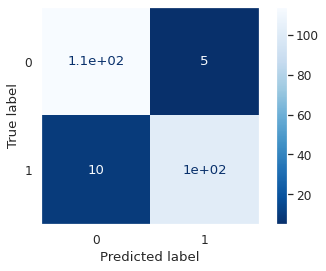

----------------------------------------------------------------
Accuracy score:  0.935064935064935
Sensitivity score:  0.9343487394957983
Specificity score:  0.9343487394957983
############## Bagging ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       119
           1       0.88      0.81      0.85       112

    accuracy                           0.86       231
   macro avg       0.86      0.86      0.86       231
weighted avg       0.86      0.86      0.86       231

----------------------------------------------------------------


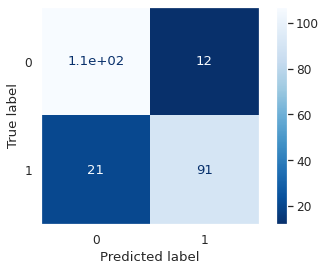

----------------------------------------------------------------
Accuracy score:  0.8571428571428571
Sensitivity score:  0.8558298319327731
Specificity score:  0.8558298319327731
############## Decision Tree ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       119
           1       0.76      0.80      0.78       112

    accuracy                           0.78       231
   macro avg       0.78      0.78      0.78       231
weighted avg       0.78      0.78      0.78       231

----------------------------------------------------------------


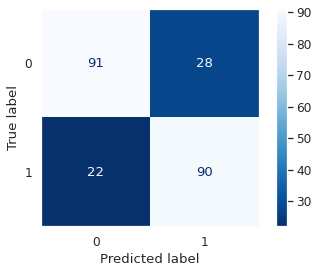

----------------------------------------------------------------
Accuracy score:  0.7835497835497836
Sensitivity score:  0.7841386554621849
Specificity score:  0.7841386554621849
############## Logistic ################
---------------------CLASSIFICATION REPORT----------------------

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       119
           1       0.92      0.94      0.93       112

    accuracy                           0.93       231
   macro avg       0.93      0.93      0.93       231
weighted avg       0.93      0.93      0.93       231

----------------------------------------------------------------


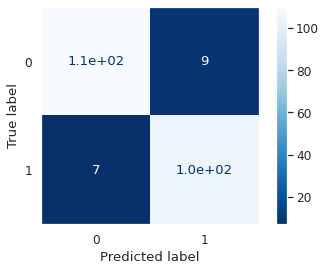

----------------------------------------------------------------
Accuracy score:  0.9307359307359307
Sensitivity score:  0.9309348739495799
Specificity score:  0.9309348739495799


In [ ]:
#classifiers
print('############## SVC ################')
svc, svc_acc, svc_sen, svc_speci = classifier(SVC(probability=True), Xtrain, ytrain)
print('############## Naive Bayes ################')
nb, nb_acc, nb_sen, nb_speci = classifier(MultinomialNB(), Xtrain, ytrain)
print('############## Random Forest ################')
rf, rf_acc, rf_sen, rf_speci = classifier(RandomForestClassifier(), Xtrain, ytrain)
print('############## XGBoost ################')
xgb, xgb_acc, xgb_sen, xgb_speci= classifier(XGBClassifier(), Xtrain, ytrain)
print('############## AdaBoost ################')
ada, ada_acc, ada_sen, ada_speci = classifier(AdaBoostClassifier(), Xtrain, ytrain)
print('############## ExtraTrees ################')
ext, ext_acc, ext_sen, ext_speci = classifier(ExtraTreeClassifier(), Xtrain, ytrain)
print('############## KNN ################')
knn, knn_acc, knn_sen, knn_speci = classifier(KNeighborsClassifier(), Xtrain, ytrain)
print('############## Catboost ################')
cat, cat_acc, cat_sen, cat_speci = classifier(CatBoostClassifier(), Xtrain, ytrain)
print('############## Gradient Boost ################')
grad, grad_acc, grad_sen, grad_speci = classifier(GradientBoostingClassifier(), Xtrain, ytrain)
print('############## Bagging ################')
bg, bg_acc, bg_sen, bg_speci = classifier(BaggingClassifier(), Xtrain, ytrain)
print('############## Decision Tree ################')
dt, dt_acc, dt_sen, dt_speci = classifier(DecisionTreeClassifier(), Xtrain, ytrain)
print('############## Logistic ################')
log, log_acc, log_sen, log_speci = classifier(LogisticRegression(), Xtrain, ytrain)

### Evaluation of Performance

In [ ]:
#performance analysis of each classifier
performance_df = pd.DataFrame(columns=['Classifier', 'Accuracy_score'])
perf_dict = {'Support Vectors': svc_acc, 'Naive Bayes': nb_acc, 'Random Forest': rf_acc, 'XGBoost': xgb_acc, 'AdaBoost': ada_acc, 'ExtraTrees': ext_acc, 
             'K-Nearest Neighbors': knn_acc, 'CatBoost': cat_acc, 'Gradient Boosting': grad_acc, 'Bagging': bg_acc, 'Decision Tree': dt_acc, 'Logistic': log_acc}
perf_dict = dict(sorted(perf_dict.items(), key=lambda val: val[1], reverse=True))
performance_df['Classifier'] = list(perf_dict.keys())
performance_df['Accuracy_score'] = list(perf_dict.values())
performance_df.style.background_gradient(cmap="Blues")
performance_graph(performance_df)

### Ensemble Building

Here, we have picked out top 3 classifiers that are performing outstandingly to build an ensemble that can outperform individual classifiers.

In [ ]:
#Ensemble model with top 3 classifier
top_classifiers = performance_df[['Classifier']][:3]
top_classifiersa

,Classifier
0,Support Vectors
1,CatBoost
2,Gradient Boosting


### Ensemble trainng and performance

Learning rate set to 0.009942
0:	learn: 0.6898666	total: 443ms	remaining: 7m 22s
1:	learn: 0.6863107	total: 754ms	remaining: 6m 16s
2:	learn: 0.6836505	total: 1.06s	remaining: 5m 53s
3:	learn: 0.6806565	total: 1.39s	remaining: 5m 45s
4:	learn: 0.6779223	total: 1.71s	remaining: 5m 40s
5:	learn: 0.6750875	total: 2.02s	remaining: 5m 34s
6:	learn: 0.6714156	total: 2.34s	remaining: 5m 32s
7:	learn: 0.6681315	total: 2.64s	remaining: 5m 27s
8:	learn: 0.6650278	total: 2.96s	remaining: 5m 25s
9:	learn: 0.6618113	total: 3.28s	remaining: 5m 25s
10:	learn: 0.6590299	total: 3.59s	remaining: 5m 22s
11:	learn: 0.6562782	total: 3.9s	remaining: 5m 21s
12:	learn: 0.6531877	total: 4.22s	remaining: 5m 20s
13:	learn: 0.6507341	total: 4.53s	remaining: 5m 18s
14:	learn: 0.6480146	total: 4.83s	remaining: 5m 17s
15:	learn: 0.6456432	total: 5.15s	remaining: 5m 16s
16:	learn: 0.6426621	total: 5.47s	remaining: 5m 16s
17:	learn: 0.6397207	total: 5.78s	remaining: 5m 15s
18:	learn: 0.6363050	total: 6.09s	remaining: 

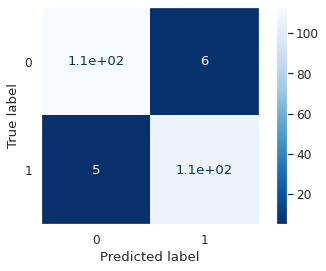

----------------------------------------------------------------
Accuracy score:  0.9523809523809523
Sensitivity score:  0.952468487394958
Specificity score:  0.952468487394958


In [ ]:
top_classifiers['estimator_instance'] = [svc, cat, grad]
top_classifiers

#fitting and ensemble
ens, ens_acc, ens_sen, ens_speci = classifier(VotingClassifier([(top_classifiers.Classifier[i], top_classifiers.estimator_instance[i]) for i in range(top_classifiers.shape[0])], 
                     voting='hard'), Xtrain, ytrain)

## **Final Results and Analysis**

In [ ]:
# Comparing Specificity of all classifiers used along with ensemble model
#senstivities
fn_sen = {'Support Vectors': svc_sen, 'Naive Bayes': nb_sen, 'Random Forest': rf_sen, 'XGBoost': xgb_sen, 'AdaBoost': ada_sen, 'ExtraTrees': ext_sen, 
             'K-Nearest Neighbors': knn_sen, 'CatBoost': cat_sen, 'Gradient Boosting': grad_sen, 'Bagging': bg_sen, 'Decision Tree': dt_sen, 'Logistic': log_sen, 'Ensembler': ens_sen}

#specificities
fn_speci = {'Support Vectors': svc_speci, 'Naive Bayes': nb_speci, 'Random Forest': rf_speci, 'XGBoost': xgb_speci, 'AdaBoost': ada_speci, 'ExtraTrees': ext_speci, 
             'K-Nearest Neighbors': knn_speci, 'CatBoost': cat_speci, 'Gradient Boosting': grad_speci, 'Bagging': bg_speci, 'Decision Tree': dt_speci, 'Logistic': log_speci, 'Ensembler': ens_speci}


In [ ]:
#plotting scores we got
def plot_scores(dict1, measure):
  names = list(dict1.keys())
  values = list(dict1.values())
  plt.figure(figsize=(15,6))
  plt.title("Fake news classification {} scores".format(measure))
  plt.bar(range(len(dict1)), values, tick_label=names, edgecolor='cyan', color='darkcyan')
  plt.xticks(rotation = 45)
  plt.xlabel("Classifiers")
  plt.ylabel(measure)
  plt.show()
 

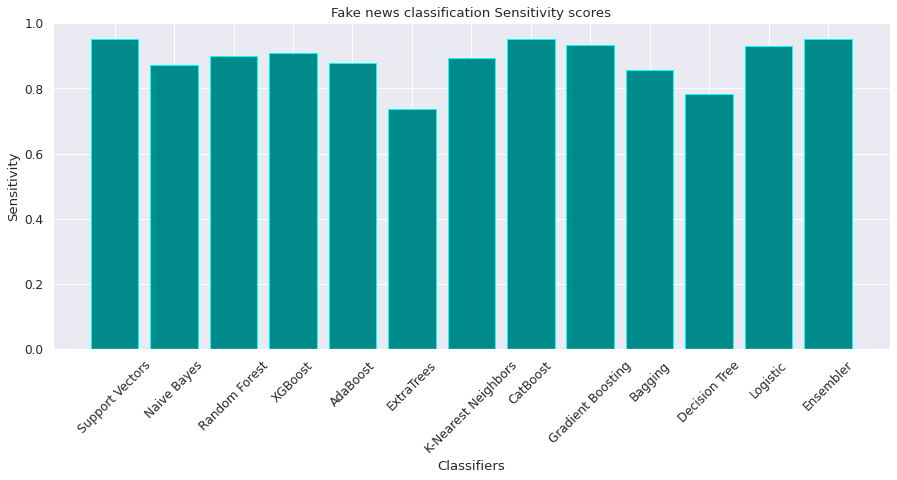

In [ ]:
## Sensitivity
plot_scores(fn_sen, measure='Sensitivity')

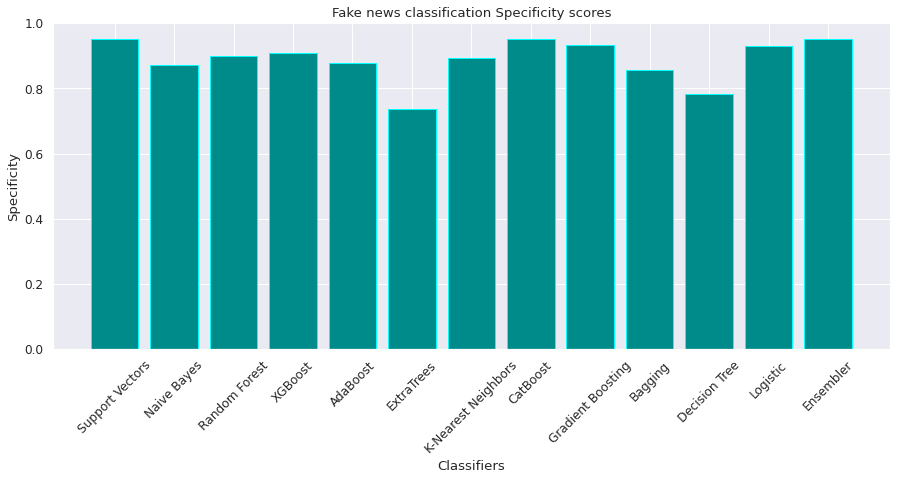

In [ ]:
## Specificity 
plot_scores(fn_speci, measure='Specificity')

# **Thank You**